# Task 1.2 DataPreparation

In [36]:
import math
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sn
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler

In [21]:
# We load the updated datasets
df_incidents = pd.read_csv('incidents_clean.csv', sep=',', index_col=0)
df_poverty = pd.read_csv('poverty.csv', sep=',', index_col=0)
df_elections = pd.read_csv('elections.csv', sep=',', index_col=0)

# Definition of new indicators

1. Ratio of the number of the killed people in the incidents w.r.t. the number of participants in the incident
2. Ratio of the number of the injured people in the incidents w.r.t. the number of participants in the incident
3. Ratio of the number of the unharmed people in the incidents w.r.t. the number of participants in the incident

In [22]:
df_incidents['ratio_killed'] = df_incidents['n_killed']/df_incidents['n_participants']*100
df_incidents['ratio_injured'] = df_incidents['n_injured']/df_incidents['n_participants']*100
df_incidents['ratio_unharmed'] = df_incidents['n_unharmed']/df_incidents['n_participants']*100

4. Indicator of the severity of the incident

In [23]:
df_incidents['severity'] = 0.5*df_incidents['ratio_killed'] + 0.3*df_incidents['ratio_injured'] + 0.2*df_incidents['ratio_unharmed']

We define a new dataframe in which we adjust the 'city_or_county' feature on the basis of lat and long.
First, we use the KMeans algorithm to create 200 different clusters on the basis of latitude and longitude.

In [24]:
df_incidents_city = df_incidents.copy()

In [26]:
# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_incidents_city[['latitude', 'longitude']])

# Choose the number of clusters (K)
k = 200

# Apply K-means clustering
kmeans = KMeans(n_clusters=k)
df_incidents_city['cluster'] = kmeans.fit_predict(data_scaled)

C:\Users\Utente\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<Axes: xlabel='longitude', ylabel='latitude'>

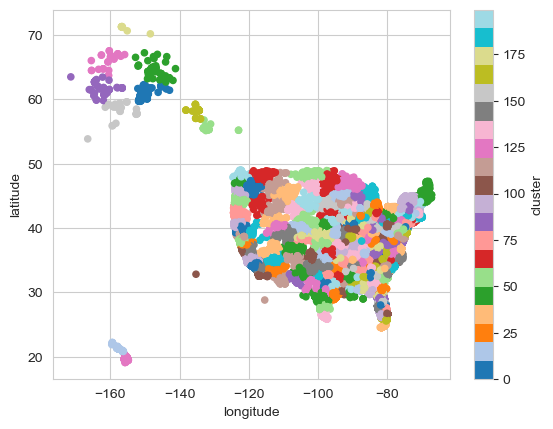

In [34]:
df_incidents_city.plot.scatter(x='longitude', y='latitude', c='cluster', cmap='tab20')

Second, we use DBSCAN

In [37]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
df_incidents_city['dbscan_clusters'] = dbscan.fit_predict(data_scaled)

MemoryError: 